In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

import math, os, random, cv2
import numpy as np
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# _URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
# path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
# PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
PATH = "E:/Projects/chubrik-kyrsach/datasets/art-mini"

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (270, 270)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
classes_num = len(train_dataset.class_names)

Found 2881 files belonging to 14 classes.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1931 files belonging to 14 classes.


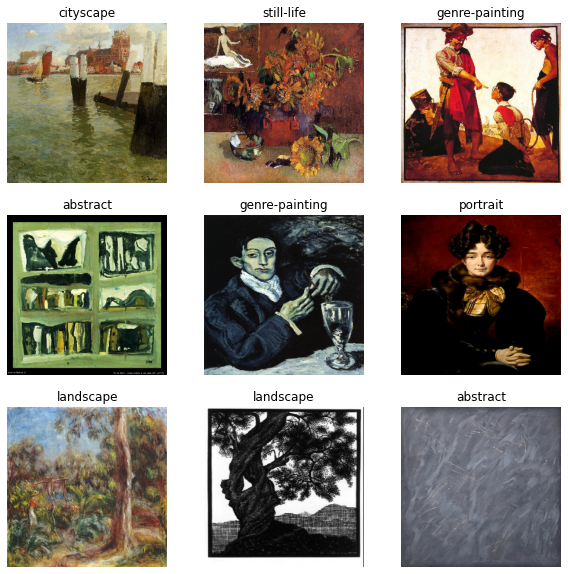

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 49
Number of test batches: 12


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

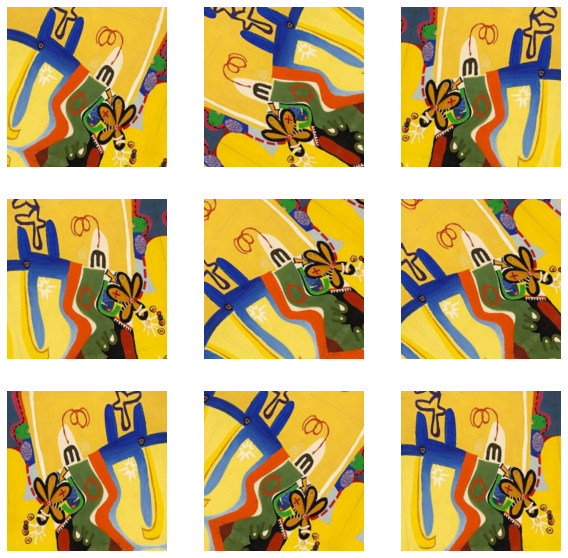

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [11]:
dir(tf.keras.applications)

['DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'EfficientNetB0',
 'EfficientNetB1',
 'EfficientNetB2',
 'EfficientNetB3',
 'EfficientNetB4',
 'EfficientNetB5',
 'EfficientNetB6',
 'EfficientNetB7',
 'EfficientNetV2B0',
 'EfficientNetV2B1',
 'EfficientNetV2B2',
 'EfficientNetV2B3',
 'EfficientNetV2L',
 'EfficientNetV2M',
 'EfficientNetV2S',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'MobileNetV3Large',
 'MobileNetV3Small',
 'NASNetLarge',
 'NASNetMobile',
 'RegNetX002',
 'RegNetX004',
 'RegNetX006',
 'RegNetX008',
 'RegNetX016',
 'RegNetX032',
 'RegNetX040',
 'RegNetX064',
 'RegNetX080',
 'RegNetX120',
 'RegNetX160',
 'RegNetX320',
 'RegNetY002',
 'RegNetY004',
 'RegNetY006',
 'RegNetY008',
 'RegNetY016',
 'RegNetY032',
 'RegNetY040',
 'RegNetY064',
 'RegNetY080',
 'RegNetY120',
 'RegNetY160',
 'RegNetY320',
 'ResNet101',
 'ResNet101V2',
 'ResNet152',
 'ResNet152V2',
 'ResNet50',
 'ResNet50V2',
 'ResNetRS101',
 'ResNetRS152',
 'ResNetRS200',
 'ResNetRS270',
 

In [12]:
preprocess_input = tf.keras.applications.resnet_rs.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [13]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNetRS270(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

515221032/515221032 [==============================] - 47s 0us/step


In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 9, 9, 2048)


In [15]:
base_model.trainable = False
base_model.summary()

Model: "resnet-rs-270"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 270, 270, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 270, 270, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 270, 270, 3)  0           ['rescaling_1[0][0]']            
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 272, 272, 3)  0          ['normalization[0][0]

 BlockGroup2__block_0__se_se_ex  (None, 1, 1, 256)   16640       ['BlockGroup2__block_0__se_se_red
 pand (Conv2D)                                                   uce[0][0]']                      
                                                                                                  
 BlockGroup2__block_0__se_se_ex  (None, 68, 68, 256)  0          ['BlockGroup2__block_0__batch_nor
 cite (Multiply)                                                 m_3[0][0]',                      
                                                                  'BlockGroup2__block_0__se_se_exp
                                                                 and[0][0]']                      
                                                                                                  
 BlockGroup2__block_0__projecti  (None, 68, 68, 256)  16384      ['stem_1_stem_act_4[0][0]']      
 on_conv (Conv2D)                                                                                 
          

                                                                                                  
 BlockGroup2__block_2__act_1 (A  (None, 68, 68, 64)  0           ['BlockGroup2__block_2_batch_norm
 ctivation)                                                      _1[0][0]']                       
                                                                                                  
 BlockGroup2__block_2__conv_2 (  (None, 68, 68, 64)  36864       ['BlockGroup2__block_2__act_1[0][
 Conv2D)                                                         0]']                             
                                                                                                  
 BlockGroup2__block_2__batch_no  (None, 68, 68, 64)  256         ['BlockGroup2__block_2__conv_2[0]
 rm_2 (BatchNormalization)                                       [0]']                            
                                                                                                  
 BlockGrou

 BlockGroup2__block_3__se_se_ex  (None, 68, 68, 256)  0          ['BlockGroup2__block_3__batch_nor
 cite (Multiply)                                                 m_3[0][0]',                      
                                                                  'BlockGroup2__block_3__se_se_exp
                                                                 and[0][0]']                      
                                                                                                  
 BlockGroup2__block_3__drop (Dr  (None, 68, 68, 256)  0          ['BlockGroup2__block_3__se_se_exc
 opout)                                                          ite[0][0]']                      
                                                                                                  
 add_3 (Add)                    (None, 68, 68, 256)  0           ['BlockGroup2__block_3__drop[0][0
                                                                 ]',                              
          

                                                                                                  
 BlockGroup3__block_1_batch_nor  (None, 34, 34, 128)  512        ['BlockGroup3__block_1__conv_1[0]
 m_1 (BatchNormalization)                                        [0]']                            
                                                                                                  
 BlockGroup3__block_1__act_1 (A  (None, 34, 34, 128)  0          ['BlockGroup3__block_1_batch_norm
 ctivation)                                                      _1[0][0]']                       
                                                                                                  
 BlockGroup3__block_1__conv_2 (  (None, 34, 34, 128)  147456     ['BlockGroup3__block_1__act_1[0][
 Conv2D)                                                         0]']                             
                                                                                                  
 BlockGrou

 BlockGroup3__block_2__se_se_ex  (None, 1, 1, 512)   66048       ['BlockGroup3__block_2__se_se_red
 pand (Conv2D)                                                   uce[0][0]']                      
                                                                                                  
 BlockGroup3__block_2__se_se_ex  (None, 34, 34, 512)  0          ['BlockGroup3__block_2__batch_nor
 cite (Multiply)                                                 m_3[0][0]',                      
                                                                  'BlockGroup3__block_2__se_se_exp
                                                                 and[0][0]']                      
                                                                                                  
 BlockGroup3__block_2__drop (Dr  (None, 34, 34, 512)  0          ['BlockGroup3__block_2__se_se_exc
 opout)                                                          ite[0][0]']                      
          

 BlockGroup3__block_4__batch_no  (None, 34, 34, 128)  512        ['BlockGroup3__block_4__conv_2[0]
 rm_2 (BatchNormalization)                                       [0]']                            
                                                                                                  
 BlockGroup3__block_4__act_2 (A  (None, 34, 34, 128)  0          ['BlockGroup3__block_4__batch_nor
 ctivation)                                                      m_2[0][0]']                      
                                                                                                  
 BlockGroup3__block_4__conv_3 (  (None, 34, 34, 512)  65536      ['BlockGroup3__block_4__act_2[0][
 Conv2D)                                                         0]']                             
                                                                                                  
 BlockGroup3__block_4__batch_no  (None, 34, 34, 512)  2048       ['BlockGroup3__block_4__conv_3[0]
 rm_3 (Bat

                                                                                                  
 add_9 (Add)                    (None, 34, 34, 512)  0           ['BlockGroup3__block_5__drop[0][0
                                                                 ]',                              
                                                                  'BlockGroup3__block_4__output_ac
                                                                 t[0][0]']                        
                                                                                                  
 BlockGroup3__block_5__output_a  (None, 34, 34, 512)  0          ['add_9[0][0]']                  
 ct (Activation)                                                                                  
                                                                                                  
 BlockGroup3__block_6__conv_1 (  (None, 34, 34, 128)  65536      ['BlockGroup3__block_5__output_ac
 Conv2D)  

 rm_3 (BatchNormalization)                                       [0]']                            
                                                                                                  
 BlockGroup3__block_7__se_se_sq  (None, 512)         0           ['BlockGroup3__block_7__batch_nor
 ueeze (GlobalAveragePooling2D)                                  m_3[0][0]']                      
                                                                                                  
 BlockGroup3__block_7__se_se_re  (None, 1, 1, 512)   0           ['BlockGroup3__block_7__se_se_squ
 shape (Reshape)                                                 eeze[0][0]']                     
                                                                                                  
 BlockGroup3__block_7__se_se_re  (None, 1, 1, 128)   65664       ['BlockGroup3__block_7__se_se_res
 duce (Conv2D)                                                   hape[0][0]']                     
          

 Conv2D)                                                         t[0][0]']                        
                                                                                                  
 BlockGroup3__block_9_batch_nor  (None, 34, 34, 128)  512        ['BlockGroup3__block_9__conv_1[0]
 m_1 (BatchNormalization)                                        [0]']                            
                                                                                                  
 BlockGroup3__block_9__act_1 (A  (None, 34, 34, 128)  0          ['BlockGroup3__block_9_batch_norm
 ctivation)                                                      _1[0][0]']                       
                                                                                                  
 BlockGroup3__block_9__conv_2 (  (None, 34, 34, 128)  147456     ['BlockGroup3__block_9__act_1[0][
 Conv2D)                                                         0]']                             
          

 educe (Conv2D)                                                  shape[0][0]']                    
                                                                                                  
 BlockGroup3__block_10__se_se_e  (None, 1, 1, 512)   66048       ['BlockGroup3__block_10__se_se_re
 xpand (Conv2D)                                                  duce[0][0]']                     
                                                                                                  
 BlockGroup3__block_10__se_se_e  (None, 34, 34, 512)  0          ['BlockGroup3__block_10__batch_no
 xcite (Multiply)                                                rm_3[0][0]',                     
                                                                  'BlockGroup3__block_10__se_se_ex
                                                                 pand[0][0]']                     
                                                                                                  
 BlockGrou

 BlockGroup3__block_12__conv_2   (None, 34, 34, 128)  147456     ['BlockGroup3__block_12__act_1[0]
 (Conv2D)                                                        [0]']                            
                                                                                                  
 BlockGroup3__block_12__batch_n  (None, 34, 34, 128)  512        ['BlockGroup3__block_12__conv_2[0
 orm_2 (BatchNormalization)                                      ][0]']                           
                                                                                                  
 BlockGroup3__block_12__act_2 (  (None, 34, 34, 128)  0          ['BlockGroup3__block_12__batch_no
 Activation)                                                     rm_2[0][0]']                     
                                                                                                  
 BlockGroup3__block_12__conv_3   (None, 34, 34, 512)  65536      ['BlockGroup3__block_12__act_2[0]
 (Conv2D) 

                                                                  'BlockGroup3__block_13__se_se_ex
                                                                 pand[0][0]']                     
                                                                                                  
 BlockGroup3__block_13__drop (D  (None, 34, 34, 512)  0          ['BlockGroup3__block_13__se_se_ex
 ropout)                                                         cite[0][0]']                     
                                                                                                  
 add_17 (Add)                   (None, 34, 34, 512)  0           ['BlockGroup3__block_13__drop[0][
                                                                 0]',                             
                                                                  'BlockGroup3__block_12__output_a
                                                                 ct[0][0]']                       
          

 Activation)                                                     rm_2[0][0]']                     
                                                                                                  
 BlockGroup3__block_15__conv_3   (None, 34, 34, 512)  65536      ['BlockGroup3__block_15__act_2[0]
 (Conv2D)                                                        [0]']                            
                                                                                                  
 BlockGroup3__block_15__batch_n  (None, 34, 34, 512)  2048       ['BlockGroup3__block_15__conv_3[0
 orm_3 (BatchNormalization)                                      ][0]']                           
                                                                                                  
 BlockGroup3__block_15__se_se_s  (None, 512)         0           ['BlockGroup3__block_15__batch_no
 queeze (GlobalAveragePooling2D                                  rm_3[0][0]']                     
 )        

                                                                 0]',                             
                                                                  'BlockGroup3__block_15__output_a
                                                                 ct[0][0]']                       
                                                                                                  
 BlockGroup3__block_16__output_  (None, 34, 34, 512)  0          ['add_20[0][0]']                 
 act (Activation)                                                                                 
                                                                                                  
 BlockGroup3__block_17__conv_1   (None, 34, 34, 128)  65536      ['BlockGroup3__block_16__output_a
 (Conv2D)                                                        ct[0][0]']                       
                                                                                                  
 BlockGrou

                                                                                                  
 BlockGroup3__block_18__se_se_s  (None, 512)         0           ['BlockGroup3__block_18__batch_no
 queeze (GlobalAveragePooling2D                                  rm_3[0][0]']                     
 )                                                                                                
                                                                                                  
 BlockGroup3__block_18__se_se_r  (None, 1, 1, 512)   0           ['BlockGroup3__block_18__se_se_sq
 eshape (Reshape)                                                ueeze[0][0]']                    
                                                                                                  
 BlockGroup3__block_18__se_se_r  (None, 1, 1, 128)   65664       ['BlockGroup3__block_18__se_se_re
 educe (Conv2D)                                                  shape[0][0]']                    
          

 BlockGroup3__block_20__conv_1   (None, 34, 34, 128)  65536      ['BlockGroup3__block_19__output_a
 (Conv2D)                                                        ct[0][0]']                       
                                                                                                  
 BlockGroup3__block_20_batch_no  (None, 34, 34, 128)  512        ['BlockGroup3__block_20__conv_1[0
 rm_1 (BatchNormalization)                                       ][0]']                           
                                                                                                  
 BlockGroup3__block_20__act_1 (  (None, 34, 34, 128)  0          ['BlockGroup3__block_20_batch_nor
 Activation)                                                     m_1[0][0]']                      
                                                                                                  
 BlockGroup3__block_20__conv_2   (None, 34, 34, 128)  147456     ['BlockGroup3__block_20__act_1[0]
 (Conv2D) 

                                                                                                  
 BlockGroup3__block_21__se_se_r  (None, 1, 1, 128)   65664       ['BlockGroup3__block_21__se_se_re
 educe (Conv2D)                                                  shape[0][0]']                    
                                                                                                  
 BlockGroup3__block_21__se_se_e  (None, 1, 1, 512)   66048       ['BlockGroup3__block_21__se_se_re
 xpand (Conv2D)                                                  duce[0][0]']                     
                                                                                                  
 BlockGroup3__block_21__se_se_e  (None, 34, 34, 512)  0          ['BlockGroup3__block_21__batch_no
 xcite (Multiply)                                                rm_3[0][0]',                     
                                                                  'BlockGroup3__block_21__se_se_ex
          

 Activation)                                                     m_1[0][0]']                      
                                                                                                  
 BlockGroup3__block_23__conv_2   (None, 34, 34, 128)  147456     ['BlockGroup3__block_23__act_1[0]
 (Conv2D)                                                        [0]']                            
                                                                                                  
 BlockGroup3__block_23__batch_n  (None, 34, 34, 128)  512        ['BlockGroup3__block_23__conv_2[0
 orm_2 (BatchNormalization)                                      ][0]']                           
                                                                                                  
 BlockGroup3__block_23__act_2 (  (None, 34, 34, 128)  0          ['BlockGroup3__block_23__batch_no
 Activation)                                                     rm_2[0][0]']                     
          

 BlockGroup3__block_24__se_se_e  (None, 34, 34, 512)  0          ['BlockGroup3__block_24__batch_no
 xcite (Multiply)                                                rm_3[0][0]',                     
                                                                  'BlockGroup3__block_24__se_se_ex
                                                                 pand[0][0]']                     
                                                                                                  
 BlockGroup3__block_24__drop (D  (None, 34, 34, 512)  0          ['BlockGroup3__block_24__se_se_ex
 ropout)                                                         cite[0][0]']                     
                                                                                                  
 add_28 (Add)                   (None, 34, 34, 512)  0           ['BlockGroup3__block_24__drop[0][
                                                                 0]',                             
          

                                                                                                  
 BlockGroup3__block_26__act_2 (  (None, 34, 34, 128)  0          ['BlockGroup3__block_26__batch_no
 Activation)                                                     rm_2[0][0]']                     
                                                                                                  
 BlockGroup3__block_26__conv_3   (None, 34, 34, 512)  65536      ['BlockGroup3__block_26__act_2[0]
 (Conv2D)                                                        [0]']                            
                                                                                                  
 BlockGroup3__block_26__batch_n  (None, 34, 34, 512)  2048       ['BlockGroup3__block_26__conv_3[0
 orm_3 (BatchNormalization)                                      ][0]']                           
                                                                                                  
 BlockGrou

                                                                                                  
 add_31 (Add)                   (None, 34, 34, 512)  0           ['BlockGroup3__block_27__drop[0][
                                                                 0]',                             
                                                                  'BlockGroup3__block_26__output_a
                                                                 ct[0][0]']                       
                                                                                                  
 BlockGroup3__block_27__output_  (None, 34, 34, 512)  0          ['add_31[0][0]']                 
 act (Activation)                                                                                 
                                                                                                  
 BlockGroup3__block_28__conv_1   (None, 34, 34, 128)  65536      ['BlockGroup3__block_27__output_a
 (Conv2D) 

 BlockGroup4__block_0__conv_3 (  (None, 17, 17, 1024  262144     ['BlockGroup4__block_0__act_2[0][
 Conv2D)                        )                                0]']                             
                                                                                                  
 BlockGroup4__block_0__batch_no  (None, 17, 17, 1024  4096       ['BlockGroup4__block_0__conv_3[0]
 rm_3 (BatchNormalization)      )                                [0]']                            
                                                                                                  
 BlockGroup4__block_0__se_se_sq  (None, 1024)        0           ['BlockGroup4__block_0__batch_nor
 ueeze (GlobalAveragePooling2D)                                  m_3[0][0]']                      
                                                                                                  
 BlockGroup4__block_0__se_se_re  (None, 1, 1, 1024)  0           ['BlockGroup4__block_0__se_se_squ
 shape (Re

                                                                 and[0][0]']                      
                                                                                                  
 BlockGroup4__block_1__drop (Dr  (None, 17, 17, 1024  0          ['BlockGroup4__block_1__se_se_exc
 opout)                         )                                ite[0][0]']                      
                                                                                                  
 add_34 (Add)                   (None, 17, 17, 1024  0           ['BlockGroup4__block_1__drop[0][0
                                )                                ]',                              
                                                                  'BlockGroup4__block_0__output_ac
                                                                 t[0][0]']                        
                                                                                                  
 BlockGrou

 BlockGroup4__block_3__conv_3 (  (None, 17, 17, 1024  262144     ['BlockGroup4__block_3__act_2[0][
 Conv2D)                        )                                0]']                             
                                                                                                  
 BlockGroup4__block_3__batch_no  (None, 17, 17, 1024  4096       ['BlockGroup4__block_3__conv_3[0]
 rm_3 (BatchNormalization)      )                                [0]']                            
                                                                                                  
 BlockGroup4__block_3__se_se_sq  (None, 1024)        0           ['BlockGroup4__block_3__batch_nor
 ueeze (GlobalAveragePooling2D)                                  m_3[0][0]']                      
                                                                                                  
 BlockGroup4__block_3__se_se_re  (None, 1, 1, 1024)  0           ['BlockGroup4__block_3__se_se_squ
 shape (Re

 BlockGroup4__block_4__output_a  (None, 17, 17, 1024  0          ['add_37[0][0]']                 
 ct (Activation)                )                                                                 
                                                                                                  
 BlockGroup4__block_5__conv_1 (  (None, 17, 17, 256)  262144     ['BlockGroup4__block_4__output_ac
 Conv2D)                                                         t[0][0]']                        
                                                                                                  
 BlockGroup4__block_5_batch_nor  (None, 17, 17, 256)  1024       ['BlockGroup4__block_5__conv_1[0]
 m_1 (BatchNormalization)                                        [0]']                            
                                                                                                  
 BlockGroup4__block_5__act_1 (A  (None, 17, 17, 256)  0          ['BlockGroup4__block_5_batch_norm
 ctivation

 shape (Reshape)                                                 eeze[0][0]']                     
                                                                                                  
 BlockGroup4__block_6__se_se_re  (None, 1, 1, 256)   262400      ['BlockGroup4__block_6__se_se_res
 duce (Conv2D)                                                   hape[0][0]']                     
                                                                                                  
 BlockGroup4__block_6__se_se_ex  (None, 1, 1, 1024)  263168      ['BlockGroup4__block_6__se_se_red
 pand (Conv2D)                                                   uce[0][0]']                      
                                                                                                  
 BlockGroup4__block_6__se_se_ex  (None, 17, 17, 1024  0          ['BlockGroup4__block_6__batch_nor
 cite (Multiply)                )                                m_3[0][0]',                      
          

 ctivation)                                                      _1[0][0]']                       
                                                                                                  
 BlockGroup4__block_8__conv_2 (  (None, 17, 17, 256)  589824     ['BlockGroup4__block_8__act_1[0][
 Conv2D)                                                         0]']                             
                                                                                                  
 BlockGroup4__block_8__batch_no  (None, 17, 17, 256)  1024       ['BlockGroup4__block_8__conv_2[0]
 rm_2 (BatchNormalization)                                       [0]']                            
                                                                                                  
 BlockGroup4__block_8__act_2 (A  (None, 17, 17, 256)  0          ['BlockGroup4__block_8__batch_nor
 ctivation)                                                      m_2[0][0]']                      
          

                                                                  'BlockGroup4__block_9__se_se_exp
                                                                 and[0][0]']                      
                                                                                                  
 BlockGroup4__block_9__drop (Dr  (None, 17, 17, 1024  0          ['BlockGroup4__block_9__se_se_exc
 opout)                         )                                ite[0][0]']                      
                                                                                                  
 add_42 (Add)                   (None, 17, 17, 1024  0           ['BlockGroup4__block_9__drop[0][0
                                )                                ]',                              
                                                                  'BlockGroup4__block_8__output_ac
                                                                 t[0][0]']                        
          

 Activation)                                                     rm_2[0][0]']                     
                                                                                                  
 BlockGroup4__block_11__conv_3   (None, 17, 17, 1024  262144     ['BlockGroup4__block_11__act_2[0]
 (Conv2D)                       )                                [0]']                            
                                                                                                  
 BlockGroup4__block_11__batch_n  (None, 17, 17, 1024  4096       ['BlockGroup4__block_11__conv_3[0
 orm_3 (BatchNormalization)     )                                ][0]']                           
                                                                                                  
 BlockGroup4__block_11__se_se_s  (None, 1024)        0           ['BlockGroup4__block_11__batch_no
 queeze (GlobalAveragePooling2D                                  rm_3[0][0]']                     
 )        

                                )                                0]',                             
                                                                  'BlockGroup4__block_11__output_a
                                                                 ct[0][0]']                       
                                                                                                  
 BlockGroup4__block_12__output_  (None, 17, 17, 1024  0          ['add_45[0][0]']                 
 act (Activation)               )                                                                 
                                                                                                  
 BlockGroup4__block_13__conv_1   (None, 17, 17, 256)  262144     ['BlockGroup4__block_12__output_a
 (Conv2D)                                                        ct[0][0]']                       
                                                                                                  
 BlockGrou

                                                                                                  
 BlockGroup4__block_14__se_se_s  (None, 1024)        0           ['BlockGroup4__block_14__batch_no
 queeze (GlobalAveragePooling2D                                  rm_3[0][0]']                     
 )                                                                                                
                                                                                                  
 BlockGroup4__block_14__se_se_r  (None, 1, 1, 1024)  0           ['BlockGroup4__block_14__se_se_sq
 eshape (Reshape)                                                ueeze[0][0]']                    
                                                                                                  
 BlockGroup4__block_14__se_se_r  (None, 1, 1, 256)   262400      ['BlockGroup4__block_14__se_se_re
 educe (Conv2D)                                                  shape[0][0]']                    
          

 BlockGroup4__block_16__conv_1   (None, 17, 17, 256)  262144     ['BlockGroup4__block_15__output_a
 (Conv2D)                                                        ct[0][0]']                       
                                                                                                  
 BlockGroup4__block_16_batch_no  (None, 17, 17, 256)  1024       ['BlockGroup4__block_16__conv_1[0
 rm_1 (BatchNormalization)                                       ][0]']                           
                                                                                                  
 BlockGroup4__block_16__act_1 (  (None, 17, 17, 256)  0          ['BlockGroup4__block_16_batch_nor
 Activation)                                                     m_1[0][0]']                      
                                                                                                  
 BlockGroup4__block_16__conv_2   (None, 17, 17, 256)  589824     ['BlockGroup4__block_16__act_1[0]
 (Conv2D) 

                                                                                                  
 BlockGroup4__block_17__se_se_r  (None, 1, 1, 256)   262400      ['BlockGroup4__block_17__se_se_re
 educe (Conv2D)                                                  shape[0][0]']                    
                                                                                                  
 BlockGroup4__block_17__se_se_e  (None, 1, 1, 1024)  263168      ['BlockGroup4__block_17__se_se_re
 xpand (Conv2D)                                                  duce[0][0]']                     
                                                                                                  
 BlockGroup4__block_17__se_se_e  (None, 17, 17, 1024  0          ['BlockGroup4__block_17__batch_no
 xcite (Multiply)               )                                rm_3[0][0]',                     
                                                                  'BlockGroup4__block_17__se_se_ex
          

 Activation)                                                     m_1[0][0]']                      
                                                                                                  
 BlockGroup4__block_19__conv_2   (None, 17, 17, 256)  589824     ['BlockGroup4__block_19__act_1[0]
 (Conv2D)                                                        [0]']                            
                                                                                                  
 BlockGroup4__block_19__batch_n  (None, 17, 17, 256)  1024       ['BlockGroup4__block_19__conv_2[0
 orm_2 (BatchNormalization)                                      ][0]']                           
                                                                                                  
 BlockGroup4__block_19__act_2 (  (None, 17, 17, 256)  0          ['BlockGroup4__block_19__batch_no
 Activation)                                                     rm_2[0][0]']                     
          

 BlockGroup4__block_20__se_se_e  (None, 17, 17, 1024  0          ['BlockGroup4__block_20__batch_no
 xcite (Multiply)               )                                rm_3[0][0]',                     
                                                                  'BlockGroup4__block_20__se_se_ex
                                                                 pand[0][0]']                     
                                                                                                  
 BlockGroup4__block_20__drop (D  (None, 17, 17, 1024  0          ['BlockGroup4__block_20__se_se_ex
 ropout)                        )                                cite[0][0]']                     
                                                                                                  
 add_53 (Add)                   (None, 17, 17, 1024  0           ['BlockGroup4__block_20__drop[0][
                                )                                0]',                             
          

                                                                                                  
 BlockGroup4__block_22__act_2 (  (None, 17, 17, 256)  0          ['BlockGroup4__block_22__batch_no
 Activation)                                                     rm_2[0][0]']                     
                                                                                                  
 BlockGroup4__block_22__conv_3   (None, 17, 17, 1024  262144     ['BlockGroup4__block_22__act_2[0]
 (Conv2D)                       )                                [0]']                            
                                                                                                  
 BlockGroup4__block_22__batch_n  (None, 17, 17, 1024  4096       ['BlockGroup4__block_22__conv_3[0
 orm_3 (BatchNormalization)     )                                ][0]']                           
                                                                                                  
 BlockGrou

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [17]:
prediction_layer = tf.keras.layers.Dense(classes_num)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 14)


In [18]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
base_learning_rate = 0.0005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 270, 270, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 270, 270, 3)       0         
                                                                 
 resnet-rs-270 (Functional)  (None, 9, 9, 2048)        128055520 
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 14)                28686     
                                                             

In [21]:
len(model.trainable_variables)

2

In [22]:
initial_epochs = len(train_dataset)

loss0, accuracy0 = model.evaluate(validation_dataset)

49/49 [==============================] - 44s 687ms/step - loss: 2.7639 - accuracy: 0.0601


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.76
initial accuracy: 0.06


In [24]:
def get_callbacks():
    return [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)]

In [25]:
with tf.device('/GPU:0'):
    history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset, callbacks=get_callbacks())

Epoch 1/91
91/91 [==============================] - 115s 1s/step - loss: 1.9091 - accuracy: 0.4134 - val_loss: 1.4484 - val_accuracy: 0.5688
Epoch 2/91
91/91 [==============================] - 99s 1s/step - loss: 1.3850 - accuracy: 0.5672 - val_loss: 1.2726 - val_accuracy: 0.5934
Epoch 3/91
91/91 [==============================] - 99s 1s/step - loss: 1.2160 - accuracy: 0.6033 - val_loss: 1.1702 - val_accuracy: 0.6257
Epoch 4/91
91/91 [==============================] - 100s 1s/step - loss: 1.1262 - accuracy: 0.6348 - val_loss: 1.1229 - val_accuracy: 0.6432
Epoch 5/91
91/91 [==============================] - 100s 1s/step - loss: 1.0427 - accuracy: 0.6567 - val_loss: 1.1157 - val_accuracy: 0.6522
Epoch 6/91
91/91 [==============================] - 99s 1s/step - loss: 1.0208 - accuracy: 0.6609 - val_loss: 1.0691 - val_accuracy: 0.6580
Epoch 7/91
91/91 [==============================] - 99s 1s/step - loss: 0.9586 - accuracy: 0.6796 - val_loss: 1.0738 - val_accuracy: 0.6619
Epoch 8/91
91/91 

In [26]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

12/12 [==============================] - 9s 684ms/step - loss: 1.1408 - accuracy: 0.6589
Test accuracy : 0.6588541865348816


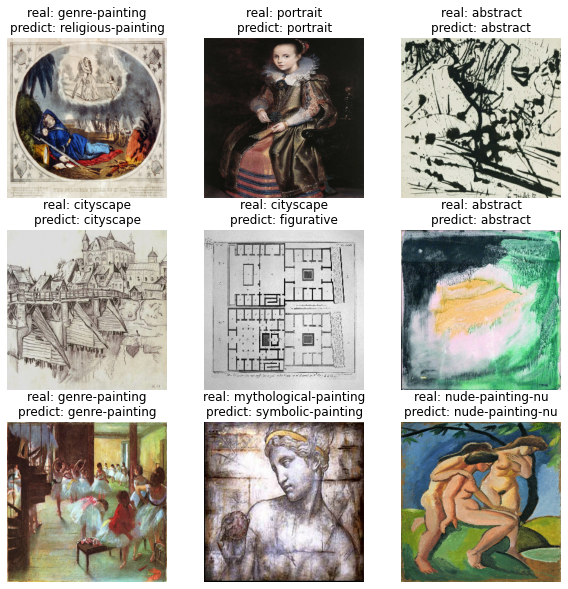

In [27]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)#.flatten()

# Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)

def arrayToIndex(a):
    l = list(a)
    return l.index(max(l))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    label_index = arrayToIndex(predictions[i])
    label = 'real: ' + class_names[label_batch[i]] + '\npredict: ' + class_names[label_index]
    plt.title(label)
    plt.axis("off")